## **Import the TensorFlow library**

This code contains a small script that is used for generating a folder full of images. The idea is to show these images to the OpenMV camera when the training with the OL methos is required. Since the idea is to apply a supervised training is required to have a ground truth forthe computation of the error that the model is doing. This script fills a directory with images of digits and creates a txt file in which all the labels are saved. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dropout, Dense, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import random 
import csv 
import sys
import os
import re
from random import seed

import time

import glob
from keras import applications
#from keras.applications import vgg19
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score

from numpy.ma.core import size

ROOT_PATH = os.path.abspath('')
sys.path.insert(0, ROOT_PATH + '/lib')
from lib.simulation_lib import *
from lib.active_lib import *

2022-10-27 16:35:19.815506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# LOAD DATASETS

In [2]:
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes from MNIST are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

The original dataset shapes from MNIST are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


In [3]:
train_samples = label_train.shape[0]
test_samples  = label_test.shape[0]
img_rows, img_cols = 28, 28

trainLow_samples = np.sum(np.where(label_train < 6, 1, 0))
testLow_samples  = np.sum(np.where(label_test  < 6, 1, 0))

# separate in containers data that is lower and higer than 6
# TRAIN - LOW
data_low_train   = np.zeros([trainLow_samples,28,28])
label_low_train  = np.zeros(trainLow_samples)
#       - HIGH
data_high_train  = np.zeros([train_samples-trainLow_samples,28,28])
label_high_train = np.zeros(train_samples-trainLow_samples)

# TEST - LOW
data_low_test   = np.zeros([testLow_samples,28,28])
label_low_test  = np.zeros(testLow_samples)

#      - HIGH
data_high_test  = np.zeros([test_samples-testLow_samples,28,28])
label_high_test = np.zeros(test_samples-testLow_samples)

j,k = 0,0
for i in range(0,train_samples):  
    if(label_train[i]<6):
        data_low_train[j,:,:] = data_train[i,:,:]
        label_low_train[j]    = label_train[i]
        j+=1
    else:
        data_high_train[k,:,:] = data_train[i,:,:]
        label_high_train[k]    = label_train[i]
        k+=1


j,k = 0,0
for i in range(0,test_samples):
    if(label_test[i]>5):
        data_high_test[k,:,:] = data_test[i,:,:]
        label_high_test[k]    = label_test[i]
        k+=1  
    else:
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        j+=1

In [4]:
# Does something I don't know
if K.image_data_format() == 'channels_first':
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], 1, img_rows, img_cols)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], 1, img_rows, img_cols)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], 1, img_rows, img_cols)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], img_rows, img_cols, 1)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], img_rows, img_cols, 1)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], img_rows, img_cols, 1)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
    
print('After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:')
print(f'     Train dataset lower than 6 has shape:  {data_low_train.shape}')
print(f'     Train dataset higher than 6 has shape: {data_high_train.shape}')
print()
print(f'     Test dataset lower than 6 has shape:  {data_low_test.shape}')
print(f'     Test dataset higher than 6 has shape: {data_high_test.shape}')

After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:
     Train dataset lower than 6 has shape:  (36017, 28, 28, 1)
     Train dataset higher than 6 has shape: (23983, 28, 28, 1)

     Test dataset lower than 6 has shape:  (6031, 28, 28, 1)
     Test dataset higher than 6 has shape: (3969, 28, 28, 1)


In [5]:
# Normalize the colors from 0-255 to 0-1
data_low_train  = data_low_train.astype(np.float32) / 255.0
data_high_train = data_high_train.astype(np.float32) / 255.0
data_low_test   = data_low_test.astype(np.float32) / 255.0
data_high_test  = data_high_test.astype(np.float32) / 255.0

# LOAD TRAINED MODEL AND FEATURES

In [6]:
# MODEL_PATH = ROOT_PATH + "/Saved_models/Backup_models/Last_trained_model/"


In [7]:
###features = np.loadtxt(MODEL_PATH + 'Original_model/ll_features_10.txt')

In [8]:
#labels_features = np.loadtxt(MODEL_PATH + 'Original_model/ll_labels_features_10.txt')
#labels_features = labels_features.astype(int)

In [9]:
#model = keras.models.load_model(MODEL_PATH + 'Original_model/mnist_cnn.h5')

In [10]:
#model_frozen = keras.models.load_model(MODEL_PATH + 'Frozen_model/omv_mnist_cnn.h5')

In [11]:
#model.summary()

# K-MEAN FUNCTIONS

In [12]:
def NumberToSoftmax(current_label, known_labels):
    ret_ary = np.zeros(len(known_labels))
                       
    for i in range(0, len(known_labels)):
        if(current_label == known_labels[i]):
            ret_ary[i] = 1

    return ret_ary



# FUNCTIONS

In [13]:
def trainOneEpoch_OL(model, x_train, x_test, y_train, y_test, features, labels_features, batch_size):
       
    cntr = 1
    learn_rate = model.l_rate
    
    train_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    tot_samples = train_samples+test_samples
    
    x_tot = np.concatenate((x_train, x_test))
    y_tot = np.concatenate((y_train, y_test))
    
    n_cluster = 10
    err_tot = 0
    cntr_clus = 0
    reminder = tot_samples%batch_size
    max_iter = int(tot_samples//batch_size)

    features_images = np.zeros(tot_samples)
        
    # FEATURE EXTRACTION

    print('**********************************\n Performing features extraction \n')

    for i in range(0, tot_samples):
        y_ML   = model.ML_frozen.predict(x_tot[i].reshape((1,28,28,1)), verbose=False)

        if i == 0:
          features_images = np.copy(y_ML)       
        else:
          features_images = np.concatenate((features_images, y_ML))

    # CLUSTERING

    print('**********************************\n Performing clustering\n')

    # Pseudo-labels
    for i in range(0, max_iter):
      
        pseudo_label, err = k_mean_clustering(features_images[i*batch_size:i*batch_size+batch_size], features, y_tot[i*batch_size:i*batch_size+batch_size], labels_features, n_cluster, batch_size, verbose = False)
        err_tot += err
        # pseudo_label = pseudo_label.astype(int)

        if i == 0:
          pseudo_labels = np.copy(pseudo_label)      
        else:
          pseudo_labels = np.append(pseudo_labels, pseudo_label)

        print(f"\r    Currently at {np.round(np.round(cntr_clus/tot_samples*batch_size,4)*100,2)}% of dataset", end="")
        print("\n")
        cntr_clus +=1
    
    # Pseudo-labels for last batch
    
    if reminder != 0: 
        pseudo_label, err = k_mean_clustering(features_images[max_iter*batch_size:tot_samples], features, y_tot[max_iter*batch_size:tot_samples], labels_features, n_cluster, reminder)
        err_tot = err_tot + err
        pseudo_labels = np.append(pseudo_labels, pseudo_label)

    # Check pseudo-labels and errors in clustering
    
    #print("Pseudo_labels vector: ")
    #print(pseudo_labels)
    #print("\n")

    # ONLINE-LEARNING

    print('**********************************\n Performing training with OL\n')

    err_mod = 0
    for i in range(0, tot_samples):

        CheckLabelKnown(model, pseudo_labels[i])
    
        y_true_soft = NumberToSoftmax(pseudo_labels[i], model.label)
               
        # Prediction
        
        y_pred = model.predict(features_images[i,:])
        
        # Backpropagation
        cost = y_pred-y_true_soft
        
        for j in range(0,model.W.shape[0]):

            # Update weights
            dW = np.multiply(cost, features_images[i,j]*learn_rate)
            model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db      = np.multiply(cost, learn_rate)
        model.b = model.b-db


        if(np.amax(y_pred) != 0):
            prediction = np.argmax(y_pred)
        print("Y predicted", prediction,"Y true", y_tot[i], "Y cluster", pseudo_labels[i])

        # Compute error
        if(y_tot[i] != prediction):
            err_mod += 1
        
        # the next part is only to plot the confusion matrix
        # if the train data is finished still train the model but do not save the results
        if(i>=train_samples):

            y_true_soft = NumberToSoftmax(y_tot[i], model.label)
                   
            # Find the max iter for both true label and prediction
            if(np.amax(y_true_soft) != 0):
                max_i_true = np.argmax(y_true_soft)

            if(np.amax(y_pred) != 0):
                max_i_pred = np.argmax(y_pred)

            # Fill up the confusion matrix
            for k in range(0,len(model.label)):
                if(model.label[max_i_pred] == model.std_label[k]):
                    p = np.copy(k)
                if(model.label[max_i_true] == model.std_label[k]):
                    t = np.copy(k)

            model.conf_matr[t,p] += 1  

        #print(f"\r    Currently at {np.round(np.round(cntr/tot_samples,4)*100,2)}% of dataset", end="")
        #print("\n")
        #cntr +=1

    print("Clustering accuracy", 100- int((err_tot/tot_samples*100)),"%")
    print("OL model accuracy", 100- int(err_mod/tot_samples*100),"%" )

# TRAIN THE MODEL ON THE DIGITS 6-9 (OL METHOD)

In [14]:
n_samples = 10000
digits_train = np.zeros((n_samples,28,28))
digits_test = np.zeros((n_samples,28,28))
label_digits_train = np.zeros(n_samples)
label_digits_test = np.zeros(n_samples)

for i in range(0, n_samples):
  n = random.randint(0,len(data_train)-1)
  digits_train[i,:,:] = data_train[n,:,:]
  label_digits_train[i] = label_train[n]
  m = random.randint(0,len(data_test)-1)
  digits_test[i,:,:] = np.copy(data_test[m,:,:])
  label_digits_test[i] = label_test[m]


if K.image_data_format() == 'channels_first':
    digits_train  = digits_train.reshape(digits_train.shape[0], 1, img_rows, img_cols)
    digits_test = digits_test.reshape(digits_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    digits_train  = digits_train.reshape(digits_train.shape[0], img_rows, img_cols, 1)
    digits_test = digits_test.reshape(digits_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

digits_train  = digits_train.astype(np.float32) / 255.0
digits_test = digits_test.astype(np.float32) / 255.0

In [15]:
print(f'The dataset on which the model will be TRAINED has shape {digits_train.shape}') # da cambiare con il nuovo set
print(f'The dataset on which the model will be TESTED has shape  {digits_test.shape}') # da cambiare con il nuovo set

The dataset on which the model will be TRAINED has shape (10000, 28, 28, 1)
The dataset on which the model will be TESTED has shape  (10000, 28, 28, 1)


In [16]:
n_feat = 10 # Select number of features
batch_size = 100 # Clustering batch size

MODEL_PATH = 'Models/{}/'.format(n_feat)
features = np.loadtxt(MODEL_PATH + 'll_features.txt')
labels_features = np.loadtxt(MODEL_PATH + 'll_labels_features.txt').astype(int)
model = keras.models.load_model(MODEL_PATH + 'original_mnist_cnn.h5') # Original model 

Model_OL = Custom_Layer(model)
Model_OL.title      = 'OL'
Model_OL.filename   = 'OL'
Model_OL.l_rate     = 0.01
Model_OL.batch_size = 8

trainOneEpoch_OL(Model_OL, digits_train, digits_test,  label_digits_train,  label_digits_test, features, labels_features, batch_size)
#trainOneEpoch_OL(Model_OL, np.concatenate((data_low_train[:25], data_high_train[:25])), np.concatenate((data_low_test[:25], data_high_test[:25])),  np.concatenate((label_low_train[:25], label_high_train[:25])),  np.concatenate((label_low_test[:25], label_high_test[:25])), features, labels_features, batch_size)

#print("The error for this batch are : ")
#print(int(err_tot/tot_samples*100))
#print("%")
#print("\n")

#plot_barChart(Model_OL)
#plot_confMatrix(Model_OL)
#plot_table(Model_OL)

2022-10-27 16:35:28.675830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**********************************
 Performing features extraction 

**********************************
 Performing clustering

    Currently at 0.0% of dataset

    Currently at 0.5% of dataset

    Currently at 1.0% of dataset

    Currently at 1.5% of dataset

    Currently at 2.0% of dataset

    Currently at 2.5% of dataset

    Currently at 3.0% of dataset

    Currently at 3.5% of dataset

    Currently at 4.0% of dataset

    Currently at 4.5% of dataset

    Currently at 5.0% of dataset

    Currently at 5.5% of dataset

    Currently at 6.0% of dataset

    Currently at 6.5% of dataset

    Currently at 7.0% of dataset

    Currently at 7.5% of dataset

    Currently at 8.0% of dataset

    Currently at 8.5% of dataset

    Currently at 9.0% of dataset

    Currently at 9.5% of dataset

    Currently at 10.0% of dataset

    Currently at 10.5% of dataset

    Currently at 11.0% of dataset

    Currently at 11.5% of dataset

    Currently at 12.0% of dataset

    Currently at 

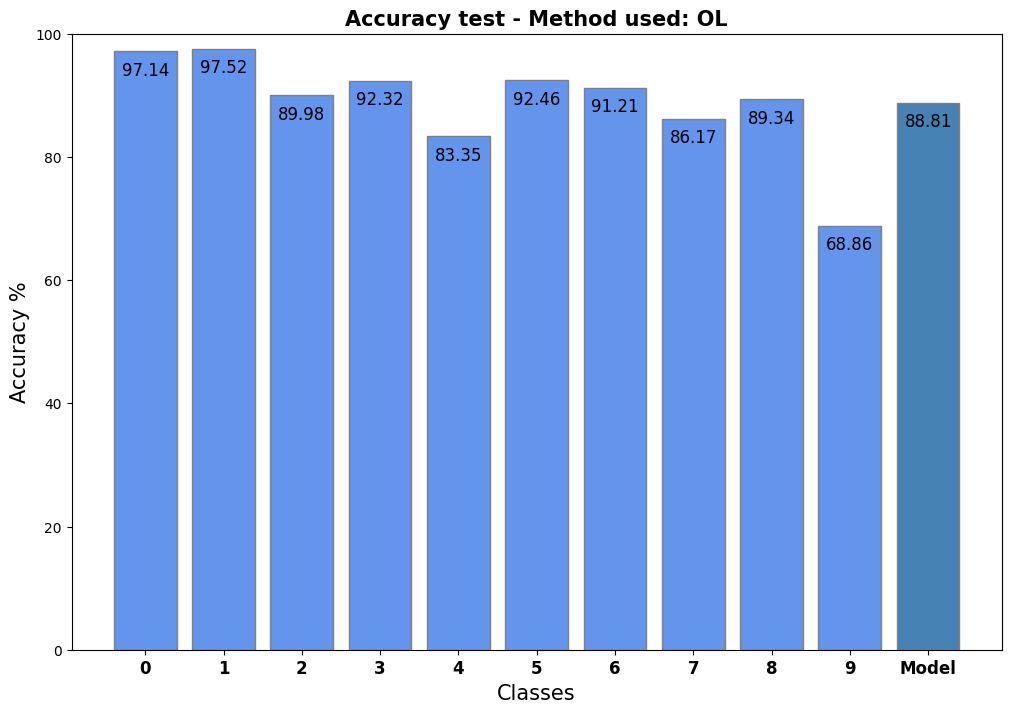

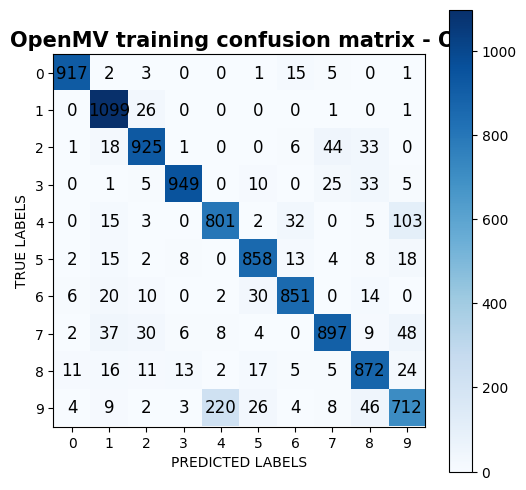

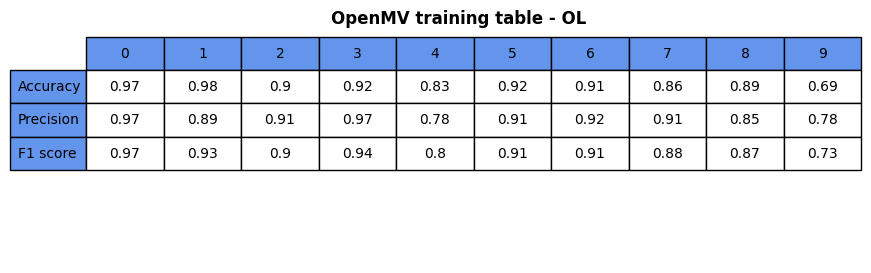

In [17]:
plot_barChart(Model_OL)
plot_confMatrix(Model_OL)
plot_table(Model_OL)